# Chapter 3 - Classification

# MNIST

- 70,000 small images of handwritten digits
- "Hello World" of machine learning

Fetch the dataset from sklearn's library

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

All datasets from sklearn have a similar structure: 

- DESCR key describing the dataset
- data key- array with one row per instance and one column per feature
- target key - array with labels

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
X.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
3      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
4      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel781  pixel782  pixel783  pixel784  
0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0  

[5 rows x 784 columns]

In [4]:
y.shape

(70000,)

70,000 images, each image with 784 features -> 28 x 28 pixels, each feature is a pixel's intensity from 0 to 255

peek at an image

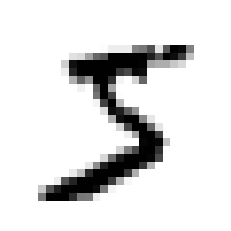

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.loc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y.loc[0]

'5'

cast y to integers

In [7]:
import numpy as np

In [8]:
y = y.astype(np.uint8)

Split the training set and test set (MNIST is already split for us)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Start by trying to identify only one digit -> is this is 5 or not? 

In [10]:
y_train_5 = (y_train==5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test==5)

Pick a classifier and train it. Start with *Stochastic Gradient Descent*
- Can efficiently handle very large datasets
- deals with training instances independently
- well suited for online learning

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDC relies on randomness (hence *stochastic*)

try a prediction on the first digit

In [12]:
sgd_clf.predict([some_digit])

array([ True])

Correct! now evaluate the model's performance

# Performance Measures

- evaluating performance on classification is usually more difficult than regressors, so going through all these might take a while. 

## Measuring Accuracy Using Cross-Validation

### Implementing cross-validation

Try implementing sklearn's cross_val_score() for more customization

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Use sklearn to do the cross validation now

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Look at a very dumb classifier that just classifies images in the 'not-5' class

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X): 
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This has over 90% accuracy becuase ~10% of the images are 5s- so if you guess than an image is not 5, then you'll be right 90% of the time. 

This is a demonstration of why accuracy is not always the preferred performance measure for classifiers- esp. with skewed datasets. 

## Confusion Matrix

Count the number of times members of class A are classified as class B and vice versa. 

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Instead of returning the evaluation scores, this returns the predictions. Clean prediction for each instance in training set (clean = prediction made by model that never saw that data during training) 

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

row = actual class<br> 
column = predicted class<br> 

- 53,892 correct classifications as not 5 (true negative)
- 687 not 5s were classified as 5s (false positive)
- 3530 correctly classified as 5 (true positive)
- 1891 were 5s were incorrectly classified as non-fives (false negatives)

**Precision**: 
$$\mbox{precision} = \frac{\mbox{TP}}{\mbox{TP} + \mbox{FP}}$$
- TP = number of true positives
- FP = number of false positives

**Recall**: 
$$\mbox{recall} = \frac{\mbox{TP}}{\mbox{TP} + \mbox{FN}}$$
- FN = number of false negatives

## Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When the model claims an image is a 5, it is correct 83.7% of the time, and it only detects 65.1% of the 5s

$F_1$ score- combine the precision and recall using the *harmonic mean* (gives more weight to low values). Will only have a high F1 score if both precision and recall are high<br> 
$$F_1 = \frac{2}{\frac{1}{\mbox{precision}} + \frac{1}{\mbox{recall}}} = 2 \times \frac{
\mbox{precision} \times \mbox{recall} }{\mbox{precision} + \mbox{recall}} = \frac{\mbox{TP}} {\mbox{TP} + \frac{\mbox{FN} + \mbox{FP}}{2}}$$


In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 score favors similar precision and recall. Sometimes you want more of one and less of the other.

## Precision / Recall tradeoff

for SGDClassifier, if a score from a *decision function* > threshold, then it assigns that datapoint to the positive class, else negative class. 

<div>
    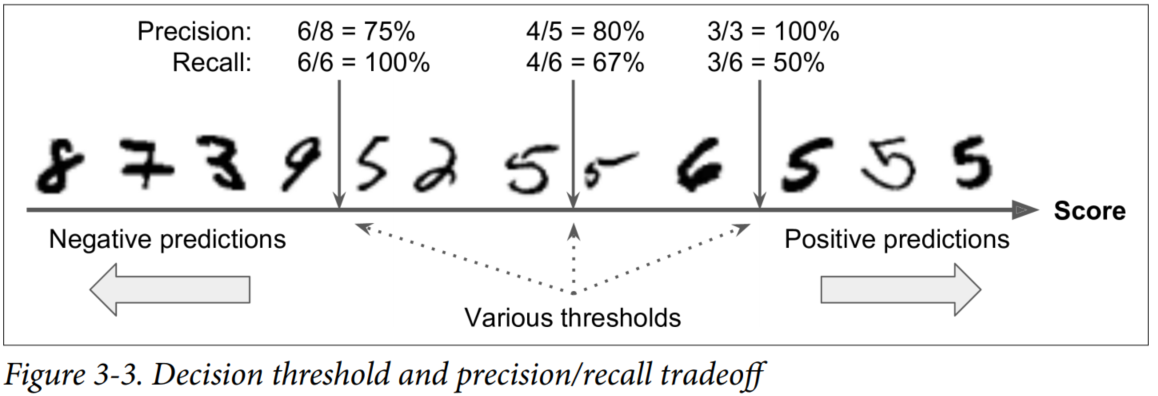
</div>

- sklearn does not let you directly change the threshold
- can return a score for each instance

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

*Raising the threshold reduces recall*<br> 

How do you decide which threshold to use? 

Get scores of all instances in the training set

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now compute precision and recall for all possible thresholds

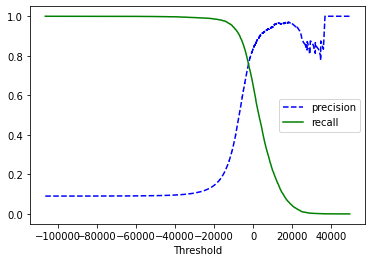

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], 'b--', label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend()
    plt.xlabel("Threshold")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Why is precision bumpier than recall? 

when increasing threshold, a true positive may get turned into a false negative (e.g. 5 gets re-classified as not 5), so the overall number of correct positive predictions goes down, thus temporarily lowering the porportion of correctly classified objects in the positive class. 

Can also plot precision directly against recall

Text(0, 0.5, 'Precision')

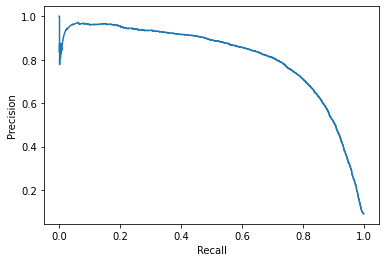

In [33]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")

Precision starts to drop around 80% recall- so try selecting a threshold right before that. Really depends on the problem at hand

Try aiming for 90% precision- search for the lowest threshold that gives at least 90% precision

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

Now make the prediction ourselves

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Note: a high precision classifier isn't useful if recall is too low

## The ROC curve

- Receiver Operating Characteristic (ROC)
- Similar to precision/recall curve
- plots *True positive rate* (aka recall) vs. *False positive rate*
- *False positive rate* - the ration of negative instances that are incorrectly classified as positive = 1 - true negative rate
- *True Negative Rate* = *Specificity*
- ROC plots *Sensitivity* (Recall) vs. 1 - *Specificity*

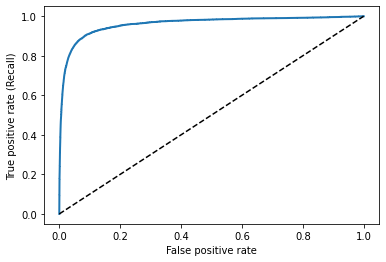

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate (Recall)")
plot_roc_curve(fpr, tpr)

Higher recall (TPR) = more false positives (FPR)<br> 
dotted line = purely random<br> 

to compare classifiers- measure *Area under the curve (AUC)*<br> 
perfect classifier: ROC AUC = 1<br> 
purely random: ROC AUC = 0.5<br> 

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

When to use ROC curve vs PR curve? <br> 

*Rule of thumb*: Prefer PR curve whenever the positive class is rare or when you care more about false positives than false negatives, otherwise ROC curve. 

This ROC curve looks really good, but that's because there are a few positives (5s) compared to the negatives (non-5s)

Next, train a RandomForestClassifier and compare the ROC curve to SGDClassifier
- Uses a predict_proba() method- array containing a row per instance and a column per class, each with a probability that the instance belongs to the given class

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

use the positive class' probability as a score

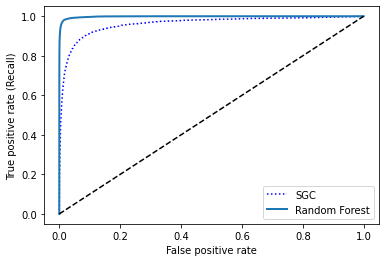

In [41]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGC")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

TODO: Measure precision and recall scores

# Multiclass Classification

- aka multinomial classifiers
- Some algorithms (e.g. Random Forest, Naive Bayes, ...) can handle this
- Others (e.g. Support Vector Machines, Linear Classifiers, ...) can't handle it directly

**One-versus-all**: (aka **One-versus-the-rest**)- train several binary classifiers (is this a 0? is this a 1? ect..), take the decision score from each, and select the class with the highest output

**One-versus-one**: Train a binary classifier for every pair of digits. For N classes, this is N x (N-1) / 2 classifiers. Each only needs to be trained on part of the training data, which is preferred for algorithms that don't scale well (e.g. Support Vector Machines). 

For most binary classifications, OvA is preferred

- sklearn can automatically detect when you're trying to use a binary classification algorithm for multi-class classification and automatically runs OvA (except that SVM defaults to OvO)

Show that this works using SGD

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint64)

Return the decision scores

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
np.argmax(some_digit_scores)

3

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64)

In [48]:
sgd_clf.classes_[5]

5

We can also force sklearn to use OvO or OvA

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint64)

In [53]:
len(ovo_clf.estimators_)

45

And try a random forest (no need for OvA or OvO this time)

In [54]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint64)

In [55]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Now try this with cross validation

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Try scaling the inputs to do better

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

- Try looking at the kinds of errors these models make

Start with confusion matrix

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Get an image representation of the confusion matrix

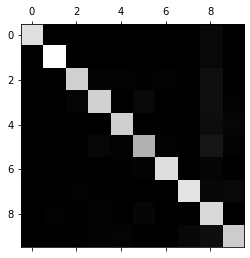

In [59]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Normalize these values against number of samples of each class

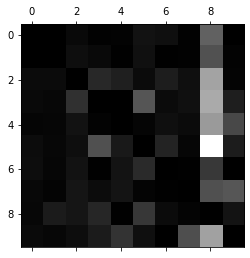

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonal with zeros to keep only errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Remember: rows represent **actual** classes, and columns represent **predicted** classes. 

Column for 8 is very bright, meaning many images are getting misclassified as 8, but the row isn't that bad, so actual 8s are getting classified properly. 

Not necessarily symmetrical. 

This can suggest ways of improving the classifier. Maybe try putting effort into reducing the number of false 8s. 
- Gather more training data for digits that look like 8s (but are not)
- engineer new features that can help distinguish patterns
- preprocess images (w/ sklearn, Pillow, or OpenCV) to make patterns stand out more


Can also try analyzing individual errors

<div> 
    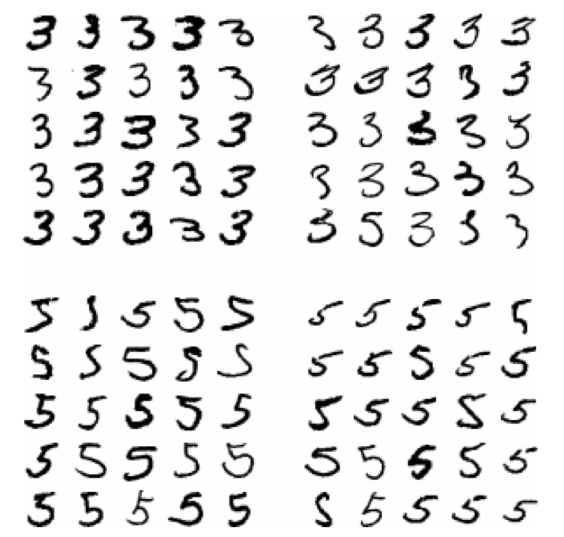
</div>

5x5 blocks on left = digits classified as 3<br> 
5x5 blocks on right show images classified as 5s<br> 

Some digits are poorly written, others we don't get why the classifier got them wrong

- SGD is a linear model, so it may be sensitive to image shifting and rotation
- Solution: preprocess images to ensure they are well-centered and not too rotated

# Multilabel Classification

- what if you want to output multiple classes for each instance? 

Look at a simple example using KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes all labels are equally important. If they're not, they can be weighted: set average="weighted". There are several other options for average. 

# Multioutput Classification

- Allow each label to be a multiclass

- Try building a system that removes noise from an image

- This is starting to blur the line between regression and classification tasks

Inputs: MINST images with noise<br> 
Targets: original images

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined